In [324]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

In [325]:
num_features = 3
num_frames = 2
input_size = num_features * num_frames
output_size = num_features

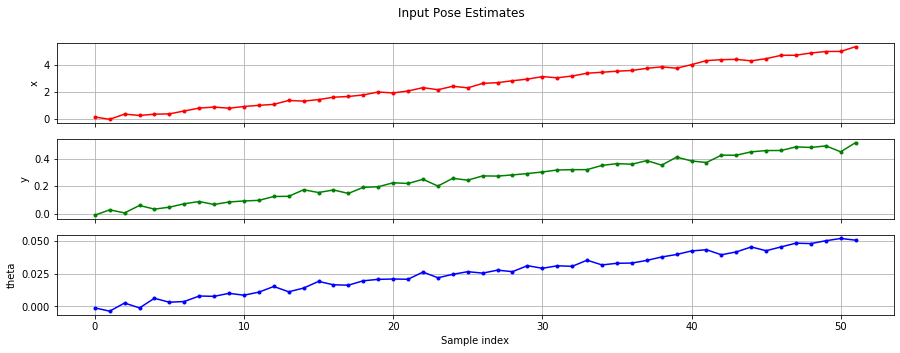

In [326]:
# Creating the artificial dataset
dim1_data = np.arange(0,5.2,0.1)
dim2_data = np.arange(0,0.52,0.01)
dim3_data = np.arange(0,0.052,0.001)

for i in range(len(dim1_data)):
    dim1_data[i] += np.random.randn()*0.1
    dim2_data[i] += np.random.randn()*0.02
    dim3_data[i] += np.random.randn()*0.002

dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()
dim2_data_scaled = (dim2_data - dim2_data.mean())/dim2_data.std()
dim3_data_scaled = (dim3_data - dim3_data.mean())/dim3_data.std()

# Plot subfigures
fig,axs = plt.subplots(3,figsize=(15,5))
fig.suptitle('Input Pose Estimates')
axs[0].plot(dim1_data,'r.-')
axs[0].set(ylabel = 'x')
axs[1].plot(dim2_data,'g.-')
axs[1].set(ylabel = 'y')
axs[2].plot(dim3_data,'b.-')
axs[2].set(ylabel = 'theta')
for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [327]:
t_x = torch.tensor(dim1_data_scaled)
t_y = torch.tensor(dim2_data_scaled)
t_theta = torch.tensor(dim3_data_scaled)

x_data = torch.zeros(len(dim1_data)-num_frames,input_size)
x_data[:,5] = t_theta[:-2]
x_data[:,4] = t_y[:-2]
x_data[:,3] = t_x[:-2]
x_data[:,2] = t_theta[1:-1]
x_data[:,1] = t_y[1:-1]
x_data[:,0] = t_x[1:-1]

y_data = torch.zeros(len(dim1_data)-num_frames,output_size)
y_data[:,0] = t_x[2:]
y_data[:,1] = t_y[2:]
y_data[:,2] = t_theta[2:]

x_rows = x_data.size()[0]
train_validate_ratio = 0.8
training_idx_limit = int(train_validate_ratio * x_rows)

x_train = x_data[:training_idx_limit,:]
x_valid = x_data[training_idx_limit:,:]

y_train = y_data[:training_idx_limit,:]
y_valid = y_data[training_idx_limit:,:]

print('x_data dimensions:',x_data.size())
print('x_train dimensions:',x_train.size())
print('x_valid dimensions:',x_valid.size())
print('y_data dimensions:',y_data.size())
print('y_train dimensions:',y_train.size())
print('y_valid dimensions:',y_valid.size())

x_data dimensions: torch.Size([50, 6])
x_train dimensions: torch.Size([40, 6])
x_valid dimensions: torch.Size([10, 6])
y_data dimensions: torch.Size([50, 3])
y_train dimensions: torch.Size([40, 3])
y_valid dimensions: torch.Size([10, 3])


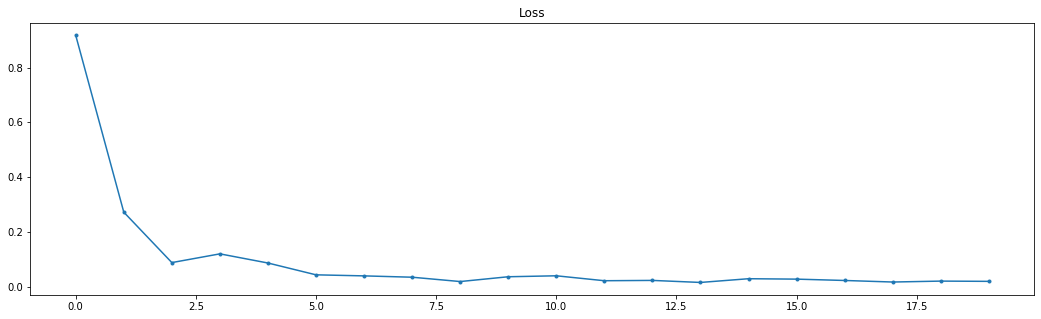

In [328]:
class Pose_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)
    
epochs = 5
lr = 0.1
model = Pose_Logistic()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=lr) 
Loss = []  # variable for storing losses after each epoch


from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
batch_size = 10
train_ds = TensorDataset(x_train,y_train)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
valid_ds = TensorDataset(x_valid,y_valid)
valid_dl = DataLoader(valid_ds,batch_size=batch_size*2)

for epoch in range(epochs):
    for xb,yb in train_dl:
        yhat = model(xb)
        loss = criterion(yhat,yb)
        Loss.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

plt.figure(figsize=(18,5))
plt.title("Loss")
plt.plot(Loss,'.-')

In [329]:
def get_model():
    model = Pose_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = criterion(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(criterion(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.5856)
1 tensor(0.2734)
2 tensor(0.1597)
3 tensor(0.1104)
4 tensor(0.0766)


In [330]:
def loss_batch(model,loss_func,xb,yb,opt=None):
    loss=loss_func(model(xb),yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(),len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [331]:
loss_func = criterion

train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.24185524880886078
1 0.10623510181903839
2 0.0686514675617218
3 0.048065148293972015
4 0.03680919483304024
